In [87]:
import numpy as np
import pandas as pd
from scipy import stats as sts
import matplotlib.pyplot as plt
import math
import seaborn as sbn
from sklearn import metrics as mts
from sklearn.datasets import load_iris
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/dima/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['grid', 'colors', 'draw']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [88]:
data = load_iris()
X = data['data'] # выборка
y = data['target'] # номера компонент смеси

In [98]:
# для каждого из классов оценим параметры распределения
sample0 = X[y == 0]
sample1 = X[y == 1]
sample2 = X[y == 2]
mean0 = np.mean(sample0, axis = 0)
mean1 = np.mean(sample1, axis = 0)
mean2 = np.mean(sample2, axis = 0)
cov0 = np.cov(sample0.T)
cov1 = np.cov(sample1.T)
cov2 = np.cov(sample2.T)
Gauss0 = sts.multivariate_normal(mean=mean0, cov=cov0)
Gauss1 = sts.multivariate_normal(mean=mean1, cov=cov1)
Gauss2 = sts.multivariate_normal(mean=mean2, cov=cov2)

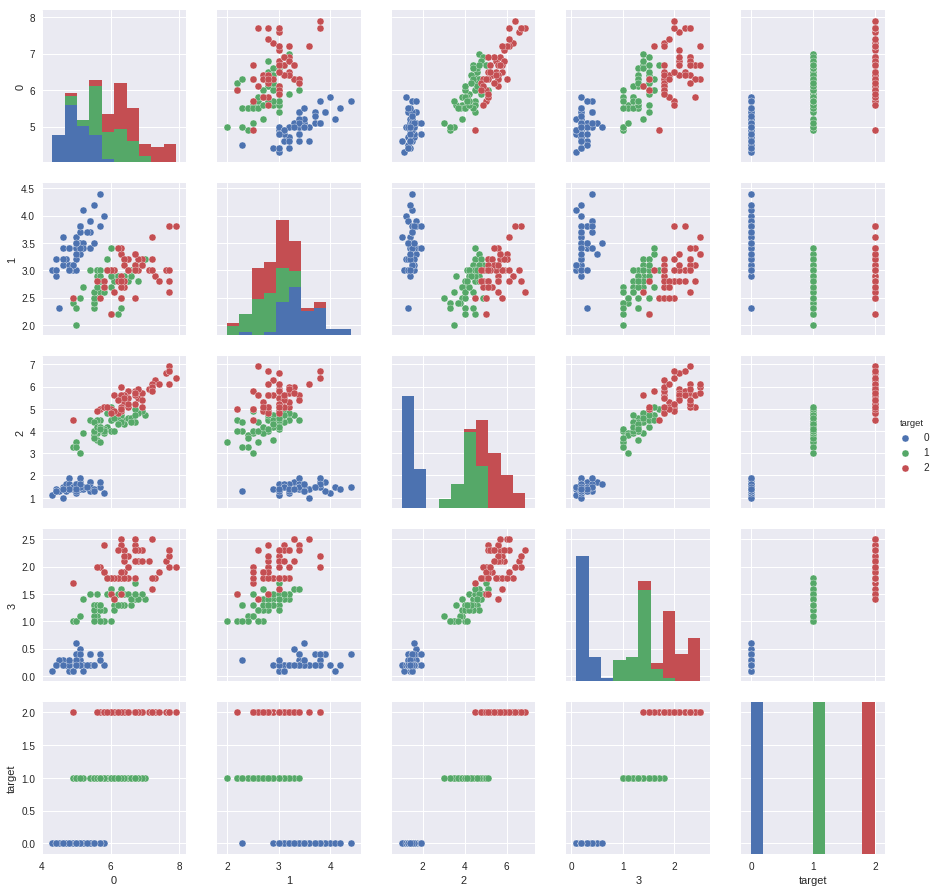

In [90]:
df = pd.DataFrame(X)
df['target'] = y
sbn.pairplot(df, hue = 'target')

In [91]:
def getVectorDensity(mean, cov, ind1, ind2):
    meanTwoDim = mean[[ind1, ind2]]
    covTwoDim = np.array([ [ cov[ind1][ind1], cov[ind1][ind2] ], 
                            [cov[ind2][ind1], cov[ind2][ind2] ] ])
    return (meanTwoDim, covTwoDim)

In [92]:
I = np.array([0, 1]) 
gauss0TwoDim = sts.multivariate_normal(*getVectorDensity(mean0, cov0, *I))
gauss1TwoDim = sts.multivariate_normal(*getVectorDensity(mean1, cov1, *I))
gauss2TwoDim = sts.multivariate_normal(*getVectorDensity(mean2, cov2, *I))

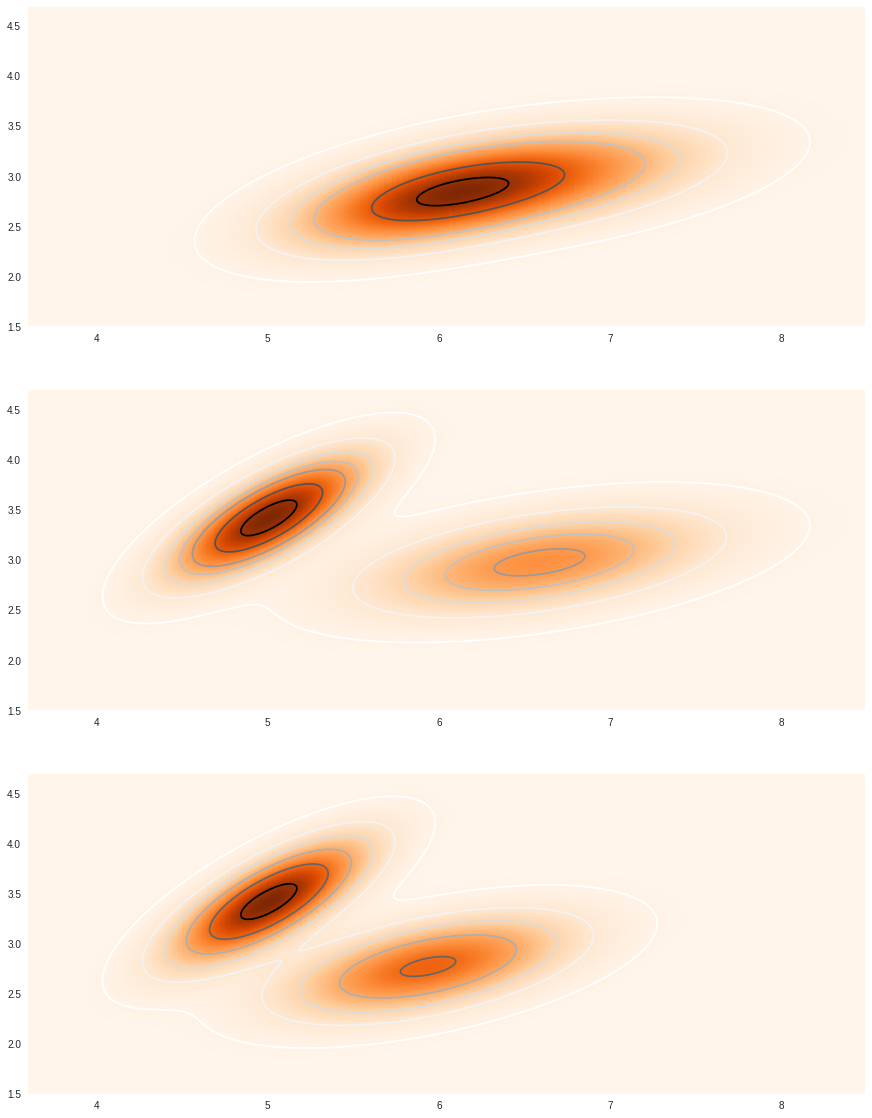

In [93]:
grid = np.mgrid[3.6:8.5:1e-2, 1.5:4.7:1e-2]
pos = np.empty(grid[0].shape + (2,))
pos[:, :, 0] = grid[0]; pos[:, :, 1] = grid[1]
density0 = 1/2 * (gauss1TwoDim.pdf(pos) + gauss2TwoDim.pdf(pos))
density1 = 1/2 * (gauss0TwoDim.pdf(pos) + gauss2TwoDim.pdf(pos))
density2 = 1/2 * (gauss0TwoDim.pdf(pos) + gauss1TwoDim.pdf(pos))
plt.figure(figsize=(15, 20))
boards = ([0.02, 0.1, 0.2, 0.3, 0.6, 0.8],
          [0.02, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8], 
          [0.02, 0.1, 0.2, 0.35, 0.55, 0.8])
for i, zip_ in enumerate(zip([density0, density1, density2], boards)):
    density, board = zip_
    plt.subplot(3, 1, i + 1)
    plt.pcolormesh(grid[0], grid[1], density, cmap='Oranges')
    plt.contour(grid[0], grid[1], density, board)
plt.show()

In [94]:
argmax_k = lambda x: np.argmax(np.array([Gauss0.pdf(x), Gauss1.pdf(x), Gauss2.pdf(x)]))

In [95]:
y_pred = np.array(list(map(lambda x: argmax_k(x), X)))
mts.accuracy_score(y_pred, y)

0.97999999999999998

In [96]:
def draw(grid, densuty_1, densuty_2, densuty_3):
    pos = np.empty(grid[0].shape + (2,))
    pos[:, :, 0] = grid[0]; pos[:, :, 1] = grid[1]
    colors = np.array(list(map(lambda x:  np.argmax(x), 
                               np.hstack((densuty_1.pdf(pos).reshape(-1, 1), 
                                          densuty_2.pdf(pos).reshape(-1, 1), 
           densuty_3.pdf(pos).reshape(-1, 1))))))
    return colors.reshape(grid[0].shape)

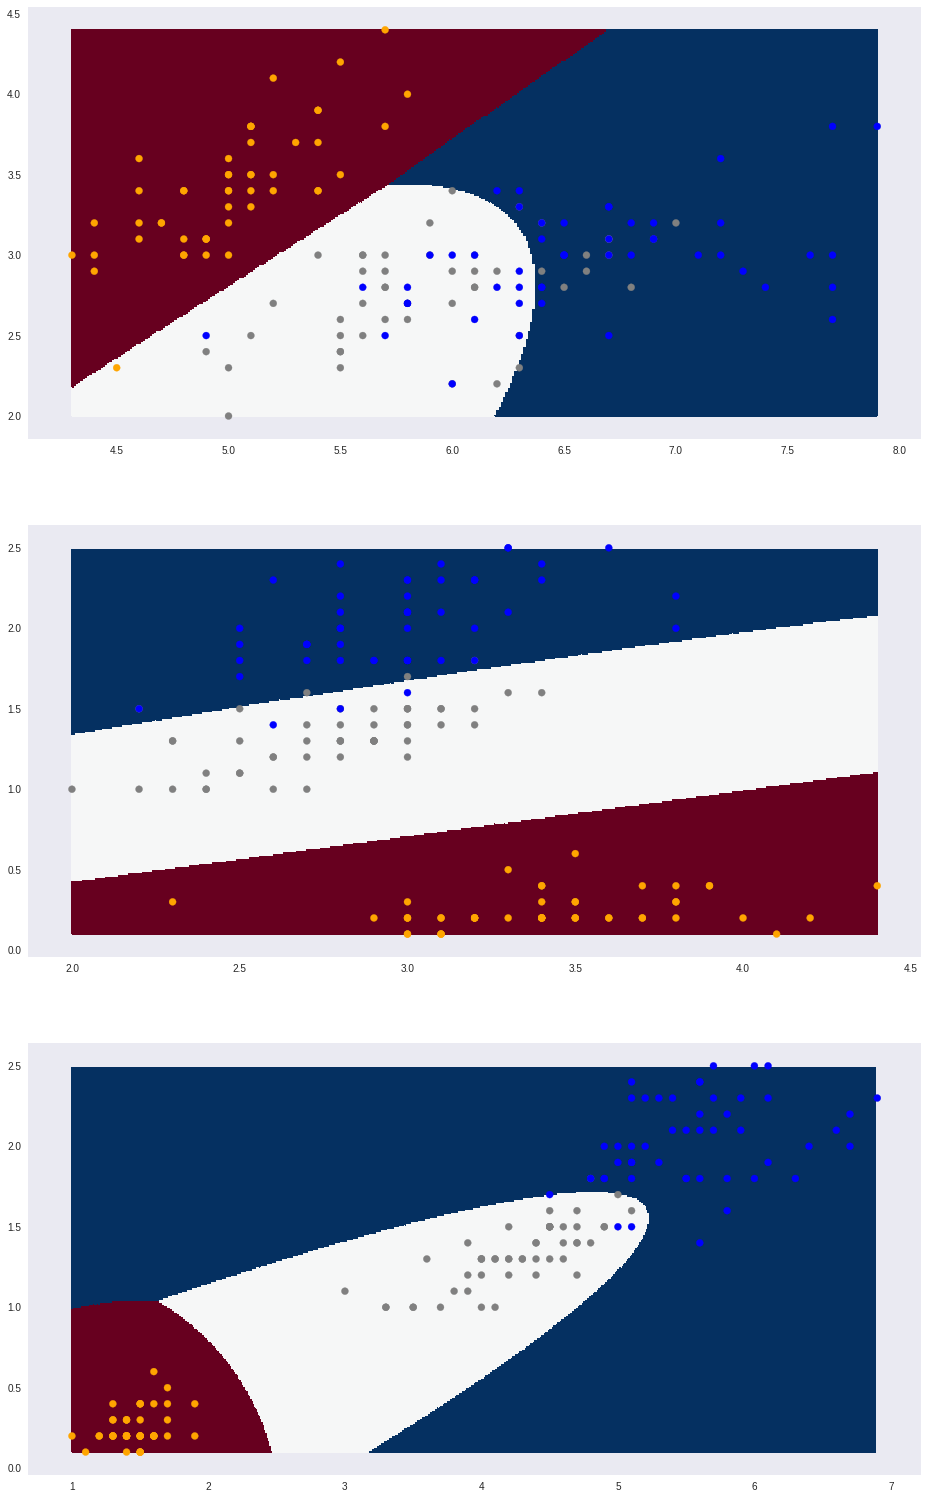

In [97]:
plt.figure(figsize=(16, 27))
for i, indexes in enumerate([(0, 1), (1, 3), (2, 3)]): 
    x_min, x_max = np.min(X[:, indexes[0]]), np.max(X[:, indexes[0]])
    y_min, y_max = np.min(X[:, indexes[1]]), np.max(X[:, indexes[1]])
    grid = np.mgrid[x_min:x_max:1e-2, y_min:y_max:1e-2]
    colors = draw(grid, sts.multivariate_normal(*getVectorDensity(mean0, cov0, *indexes)), 
              sts.multivariate_normal(*getVectorDensity(mean1, cov1, *indexes)), 
              sts.multivariate_normal(*getVectorDensity(mean2, cov2, *indexes)))
    plt.subplot(3, 1, i + 1)
    plt.pcolormesh(grid[0], grid[1], colors, cmap='RdBu')
    colors_map = ['orange', 'gray', 'blue']
    plt.scatter(X[:, indexes[0]], X[:, indexes[1]], 
                color=list(map(lambda y_once: colors_map[y_once], y)))
plt.show()